In [14]:
# ----------------------------------------
# 1. Import necessary libraries for modeling
# ----------------------------------------
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pickle
import lzma

In [ ]:
# ----------------------------------------
# 2. Load the cleaned dataset and prepare features
# ----------------------------------------

# Load dataset
df = pd.read_csv("../data/cleaned_data_v2.csv")

# Convert time column to datetime and extract useful time features
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Hour"] = df["Time"].dt.hour
df["Weekday"] = df["Time"].dt.day_name()
df["Year"] = df["Time"].dt.year
df["Day_of_Year"] = df["Time"].dt.dayofyear

# Rename some columns to English
df.rename(columns={
    "Månad": "Month",
    "Län": "County",
    "Kommun": "Municipality",
    "Art": "Species"
}, inplace=True)

# Drop rows with missing important values
df = df.dropna(subset=["County", "Species", "Weekday", "Hour", "Month", "Lat_WGS84", "Long_WGS84"])

# Create a target variable: number of collisions in each group
df["n_collisions"] = df.groupby(["County", "Species", "Month", "Hour"])["Time"].transform("count")

# Bin the collision counts into 5 risk categories
df["risk_label"] = pd.qcut(df["n_collisions"], 5, labels=["Very Low", "Low", "Moderate", "High", "Very High"])

# Define features to use in the model
features = [
    "Year", "Month", "Hour", "Weekday", "County",
    "Species", "Municipality", "Day_of_Year", "Lat_WGS84", "Long_WGS84"
]

# Define input features and target
X = df[features].copy()
y = df["risk_label"]

In [16]:
# ----------------------------------------
# 3. Split dataset into training and testing sets
# ----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
# ----------------------------------------
# 4. Set up preprocessing for numerical and categorical features
# ----------------------------------------

num_features = ["Month", "Hour", "Day_of_Year", "Lat_WGS84", "Long_WGS84"]
cat_features = ["Weekday", "County", "Species", "Municipality"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [18]:
# ----------------------------------------
# 5. Create model pipeline and perform GridSearchCV
# ----------------------------------------

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

# Perform grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Print the best parameters found
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


              precision    recall  f1-score   support

        High       0.79      0.83      0.81      5508
         Low       0.73      0.65      0.69      5283
    Moderate       0.77      0.77      0.77      5995
   Very High       0.87      0.95      0.91      5684
    Very Low       0.85      0.83      0.84      6226

    accuracy                           0.81     28696
   macro avg       0.80      0.81      0.80     28696
weighted avg       0.81      0.81      0.81     28696



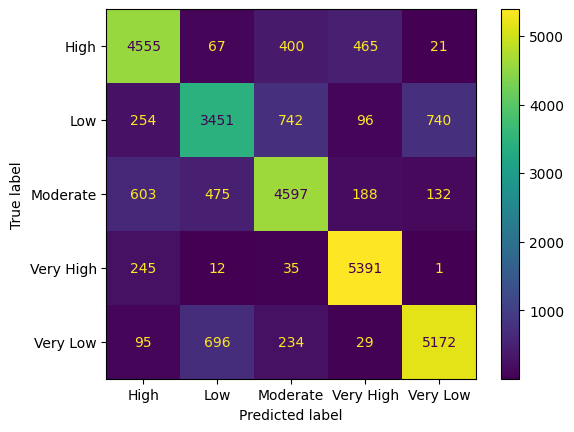

In [19]:
# ----------------------------------------
# 6. Evaluate the model on the test set
# ----------------------------------------

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)
plt.show()

In [20]:
# ----------------------------------------
# 7. Save the trained model and encoded feature names (compressed)
# ----------------------------------------

model = grid.best_estimator_

with lzma.open("model/model.pkl.xz", "wb") as f:
    joblib.dump(model, f)

feat_names = model.named_steps["pre"].get_feature_names_out()
with open("model/model_columns.pkl", "wb") as f:
    pickle.dump(feat_names.tolist(), f)

print("✅ Compressed model and columns saved.")

✅ Compressed model and columns saved.
